Import the neccessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
import warnings

In [2]:
# Supress all future warnings to keep the output clean
warnings.filterwarnings("ignore")

Load and Initial Data Exploration

In [3]:
# Load the dataset (using the file provided in the environment)
# The dataset cotains movie reviews and their corresponding sentiment (positive/negative)
try:
    df = pd.read_csv("imdb.csv")
except FileNotFoundError:
    print("Error: 'imdb.csv' was not found. Please ensure the file is accessible")
    exit()

In [4]:
# Display the Data Information
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None


In [5]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


===== Target Distribution (Sentiment) Before Training =====
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


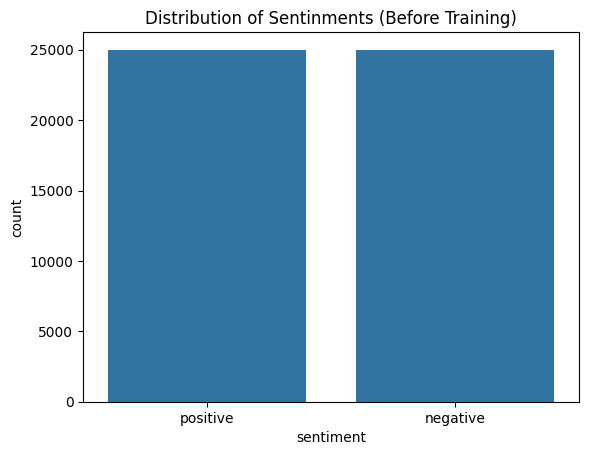

In [8]:
# Check the distribution of the target variable (sentiment)
# This is cruical to identify if the dataset is balanced or imbalanced
print("===== Target Distribution (Sentiment) Before Training =====")
print(df["sentiment"].value_counts())
plt.Figure(figsize=(6,4))
sns.countplot(x="sentiment",data=df)
plt.title("Distribution of Sentinments (Before Training)")
plt.show() # Visualization: Before Training -  Target Distribution

Data Preprocessing

In [15]:
# Number of elemnents in the data
print("===== Number of Elements =====")
len(df)

===== Number of Elements =====


50000

In [16]:
# Check for missing values
df_missing = df.isnull().sum()
print("===== Missing Values =====")
print(df_missing)

===== Missing Values =====
review       0
sentiment    0
dtype: int64


In [17]:
# Check for duplicated rows
df_duplicated = df.duplicated().sum()
print("===== Duplicated Rows =====")
print(df_duplicated)

===== Duplicated Rows =====
418


In [22]:
# Drop duplicated rows
df.drop_duplicates(inplace=True)

In [23]:
# Check for duplicated rows
df_duplicated = df.duplicated().sum()
print("===== Duplicated Rows =====")
print(df_duplicated)

===== Duplicated Rows =====
0


===== Target Distribution (Sentiment) Before Training =====
sentiment
positive    24884
negative    24698
Name: count, dtype: int64


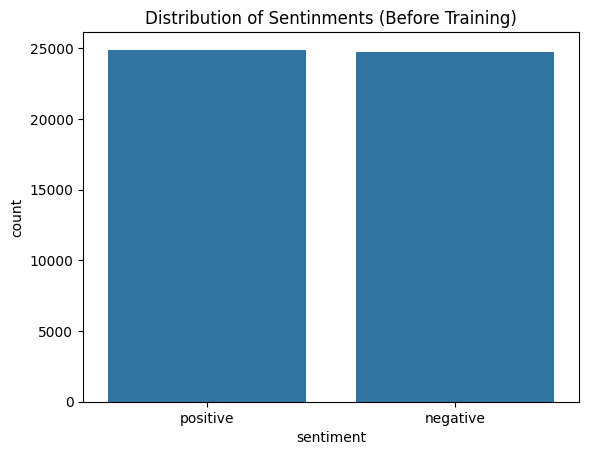

In [24]:
# Check the distribution of the target variable (sentiment)
# This is cruical to identify if the dataset is balanced or imbalanced
print("===== Target Distribution (Sentiment) Before Training =====")
print(df["sentiment"].value_counts())
plt.Figure(figsize=(6,4))
sns.countplot(x="sentiment",data=df)
plt.title("Distribution of Sentinments (Before Training)")
plt.show() # Visualization: Before Training -  Target Distribution

Data Encoding

In [25]:
# Encode the categorical target variable ("sentinment") into numerical format (0 and 1)
# "positive" -> 1, "Negative" -> 0
le = LabelEncoder()
df["sentiment_encoded"] = le.fit_transform(df["sentiment"])
# The classes are encoded are mapped: 0 is "negative", 1 is "positive"
print(f"Encoded Classes: {dict(zip(le.classes_,le.transform(le.classes_)))}")

Encoded Classes: {'negative': np.int64(0), 'positive': np.int64(1)}


Feature Engineering

In [26]:
#  Define features (X -the "review" text) and target (y - the "sentinment_encoded")
X = df["review"]
y = df["sentiment_encoded"]

Data Splitting

In [27]:
# Split the data into training and testing sets
# The test size is 20% (random_state=42 ensures reproducibily)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

Model Pipeline Setup and Comparison

In [28]:
# We will compare three common classification algorithms:
# 1. Logistic Regression (Simple, highly interpretable linear model)
# 2. Decision Tree (Non-linear,captures complex rules, but prone to overfitting)
# 3. Multinominal Naive Bayes (Probabilistic, excellent for text classification due to TF-IDF features)

# A Pipeline is used to chain the preprocessing step (TF-IDF Vectorization) and the classifier
# TF-IDF (Term Frequency-Inverse Document Frequency) converts text into a numerical feature matrix
# It assigns a weight to each word based on its frequency in a document relative to its frequency across all documents

pipelines = {
    "LogisticRegression":Pipeline([
        ("tfidf",TfidfVectorizer(stop_words="english")),
        ("clf",LogisticRegression(random_state=42))
    ]),
    "DecisionTree":Pipeline([
        ("tfidf",TfidfVectorizer(stop_words="english")),
        ("clf",DecisionTreeClassifier(random_state=42))
    ]),
    "MultinomialNB":Pipeline([
        ("tfidf",TfidfVectorizer(stop_words="english")),
        ("clf",MultinomialNB())
    ])
}

In [29]:
# Dictionary to store performance metris for comparison
results = {}

In [1]:
# Iterate through each pipeline,train the model and evaluate its performance
print("----- Initial Model Training and Evaluation (Before Tuning) -----")
for name,pipeline in pipelines.items():
    print(f"Training {name}......")

    # Train the pipeline: Vectorization and classification are done in one step
    pipeline.fit(X_train,y_train)

    # Predict the target on the test set
    y_pred = pipeline.predict(X_test)

    # Calculate and store the accuracy score
    accuracy = accuracy_score(y_test,y_pred)
    results[name] = accuracy

    print(f"{name} Accuracy: {accuracy:.4f}")
    # Show the full classification report (precison,recall,f1-score)
    print(classification_report(y_test,y_pred,target_names=["negative","positive"]))

    # Visualization: Confusion Matrix for initial models
    cm = confusion_matrix(y_test,y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm,annot=True,fmt="d",cmap="Blues",
                xticklabels=["negative","positive"],
                yticklabels=["negative","positive"])
    plt.title(f"Confusion Matrix for {name} (Initial)")
    plt.ylabel("Actual Label")
    plt.xlabel("Predicted Label")
    plt.show() # Visualization: Initial Confusion Matrix

----- Initial Model Training and Evaluation (Before Tuning) -----


NameError: name 'pipelines' is not defined

Hyperparameter Tuning for Logistic Regression

In [41]:
# Defin the parameter grid for Logistic Regression
# "tfidf__ngram_range": The range of word combinations to use (e.g, single words, or pairs of words)
# "clf__C": Inverse of regularization strength (smaller values specify stronger regularization)
param_grid_lr = {
    "tfidf__ngram_range":[(1,1),(1,2)],  # Unigrams (1,1) or Unigrams and Biagrams (1,2)
    "clf__C":[0.1,1,10],  # Regularization strength C
    "clf__solver":["liblinear"]
}

In [42]:
#  Create a new pipeline for tuning
lr_pipeline = Pipeline([
    ("tfidf",TfidfVectorizer(stop_words="english")),
    ("clf",LogisticRegression(random_state=42,max_iter=1000)) # Increased max_iter for convergence
])

In [43]:
# Setup GridSearchCV with 3-fold cross-valiadtion
grid_search_lr = GridSearchCV(lr_pipeline,param_grid_lr,cv=3,verbose=3,n_jobs=-1,scoring="accuracy")

In [44]:
# Execute the grid search on the training data
grid_search_lr.fit(X_train,y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'clf__C': [0.1, 1, ...], 'clf__solver': ['liblinear'], 'tfidf__ngram_range': [(1, ...), (1, ...)]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,3
,verbose,3
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,input,'content'


In [45]:
# Store the best model and its score
best_lr_model = grid_search_lr.best_estimator_
best_lr_score = grid_search_lr.best_score_

In [46]:
print(f"Best Cross-validation Accuracy (Logistic Regression): {best_lr_score:.4f}")
print(f"Best Parameters Found: {grid_search_lr.best_params_}")

Best Cross-validation Accuracy (Logistic Regression): 0.8965
Best Parameters Found: {'clf__C': 10, 'clf__solver': 'liblinear', 'tfidf__ngram_range': (1, 2)}


Final Evaluation of Tuned Model

In [47]:
# Evaluate the best model on the unseen test data
y_pred_tuned = best_lr_model.predict(X_test)
tuned_accuracy = accuracy_score(y_test,y_pred_tuned)

print("----- Final Evauation of Hyperparameter-Tuned Logistic Regression -----")
print(f"Tuned Logistic Regression Test Accuracy: {tuned_accuracy:.4f}")
print(classification_report(y_test,y_pred_tuned,target_names=["negative","positive"]))

----- Final Evauation of Hyperparameter-Tuned Logistic Regression -----
Tuned Logistic Regression Test Accuracy: 0.8999
              precision    recall  f1-score   support

    negative       0.91      0.88      0.90      4939
    positive       0.89      0.92      0.90      4978

    accuracy                           0.90      9917
   macro avg       0.90      0.90      0.90      9917
weighted avg       0.90      0.90      0.90      9917



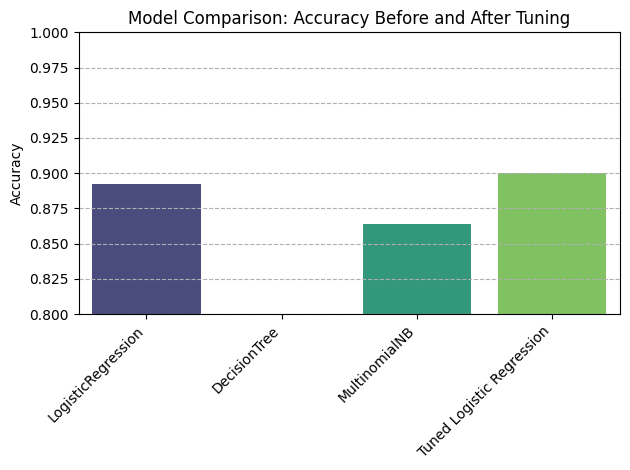

In [48]:
# Visualization: Final Comparison of Model Accuracies
results['Tuned Logistic Regression'] = tuned_accuracy

plt.Figure(figsize=(10,6))
model_names = list(results.keys())
accuracies = list(results.values())
sns.barplot(x=model_names,y=accuracies,palette="viridis")
plt.ylim(0.8,1.0) # Set reasonable limits for classification accuracy
plt.title("Model Comparison: Accuracy Before and After Tuning")
plt.ylabel("Accuracy")
plt.xticks(rotation=45,ha="right")
plt.grid(axis="y",linestyle="--")
plt.tight_layout()
plt.show() # Visualization After Training - Model Comparison

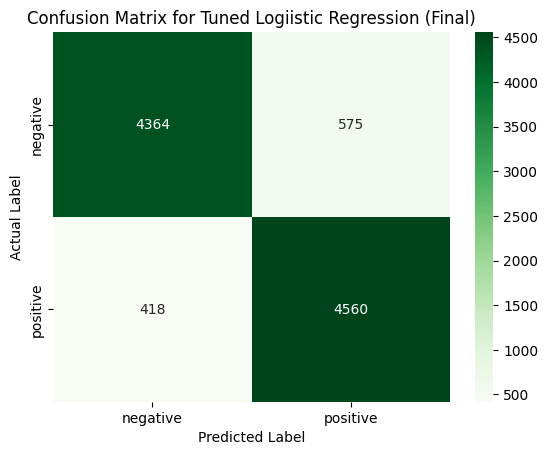

In [49]:
# Visualization: Confusion Matrix for the final best model
cm_tuned = confusion_matrix(y_test,y_pred_tuned)
plt.Figure(figsize=(5,4))
sns.heatmap(cm_tuned,annot=True,fmt="d",cmap="Greens",
            xticklabels=["negative","positive"],
            yticklabels=["negative","positive"])
plt.title("Confusion Matrix for Tuned Logiistic Regression (Final)")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show() # Visualization: Final Tuned Confusion Matrix

Function for New Prediction

In [50]:
# Define a function to take a new review and predict its sentiment using the best model
def predict_new_review(model):
    print("----- New Prediction Input -----")
    print("Enter a movie review to predict its sentiment (type 'exit' to quit):")

    while True:
        # Get user input for a new review
        new_review = input("Your Review:")
        if new_review.lower() == "exit":
            break
        if not new_review.strip():
            print("Please enter a non-empty review.")
            continue

        # Predict the sentinment. The model handles the TF-IDF vectorization automatically.
        prediction_encoded = model.predict([new_review])[0]

        # Convert the numerical prediction back to the original label (positive or negative)
        prediction_label = le.inverse_transform([prediction_encoded])[0]

        # Get the probability (confidence score) of the prediction
        # The probabiliity of the predicted class is [:,predicted_encoded]
        # [0] is used because we only pass one review
        prediction_proba = model.predict_proba([new_review])[0][prediction_encoded]

        print(f"Predicted Sentinment: {prediction_label.upper()}")
        print(f"Confidence Score: {prediction_proba:.4f}")


# Run the prediction function with best-tuned model
predict_new_review(best_lr_model)

----- New Prediction Input -----
Enter a movie review to predict its sentiment (type 'exit' to quit):
Predicted Sentinment: NEGATIVE
Confidence Score: 0.9999
Predicted Sentinment: NEGATIVE
Confidence Score: 0.8770
Predicted Sentinment: NEGATIVE
Confidence Score: 0.5123
Predicted Sentinment: NEGATIVE
Confidence Score: 1.0000
Predicted Sentinment: POSITIVE
Confidence Score: 0.9972
Predicted Sentinment: POSITIVE
Confidence Score: 0.9987
Please enter a non-empty review.
Please enter a non-empty review.
